# Initial Try

followed some YouTube tutorials to get more acustomed to Groq and what it can be.

In [1]:
!pip install -q groq PyPDF2

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 131.1/131.1 kB 10.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 232.6/232.6 kB 18.8 MB/s eta 0:00:00


In [16]:
from google.colab import userdata
userdata.get('GROQ_API_KEY')

In [16]:
import os
from groq import Groq

client = Groq(

              api_key=userdata.get('GROQ_API_KEY'),
)

chat_completion = client.chat.completions.create(
    messages=[

    {"role": "user",
     "content": "Why is Spongebob not a circle?"},
    ],

    model="llama3-8b-8192",
)

print(chat_completion.choices[0].message.content)

# Sample Outputs

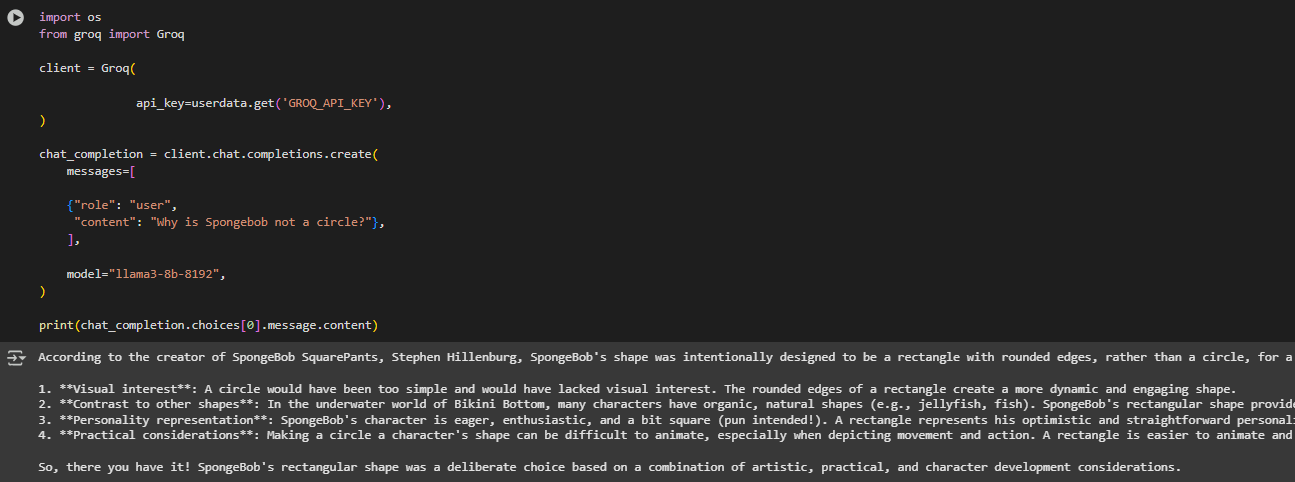

# Q&A From Uploaded File

Now to limit the model's knowledge and to ensure that it will behave withing a context. allow for file (CVS, TXT, PDF, JSON ) upload and edit the prompt so that it limits the model to answer only based on what it given

In [7]:
import os
import io
from groq import Groq
from google.colab import files, userdata
import PyPDF2
import pandas as pd
import json

client = Groq(api_key=userdata.get('GROQ_API_KEY'))

In [9]:
def extract_text_from_file(uploaded_bytes, filename):
    filename = filename.lower()
    if filename.endswith('.json'):
        data = json.loads(uploaded_bytes.decode('utf-8'))
        return json.dumps(data, indent=2)[:10000]

    elif filename.endswith('.pdf'):

        with io.BytesIO(uploaded_bytes) as pdf_file:
            reader = PyPDF2.PdfReader(pdf_file)
            return "\n".join([page.extract_text() for page in reader.pages])

    elif filename.endswith('.csv'):

        return pd.read_csv(io.BytesIO(uploaded_bytes)).to_string()

    elif filename.endswith('.txt'):

        return uploaded_bytes.decode('utf-8')

    else:
        raise ValueError("Unsupported file type. Use PDF/CSV/JSON/TXT.")

In [10]:
def query_model(text, question):
    prompt = f"""Answer from this text only:
    {text[:8000]}  # Strict truncation

    Question: {question}"""
    try:
        response = client.chat.completions.create(
            messages=[{"role": "user", "content": prompt}],
            model="llama3-8b-8192",
        )
        return response.choices[0].message.content
    except Exception as e:
        return f"Error: {str(e)}"

In [16]:
uploaded = files.upload()
filename = next(iter(uploaded))
document_text = extract_text_from_file(uploaded[filename], filename)

while True:
    user_question = input("\nAsk a question (or 'quit'): ")
    if user_question.lower() == 'quit':
        break
    print("\nAnswer:", query_model(document_text, user_question))

# Sample Outputs

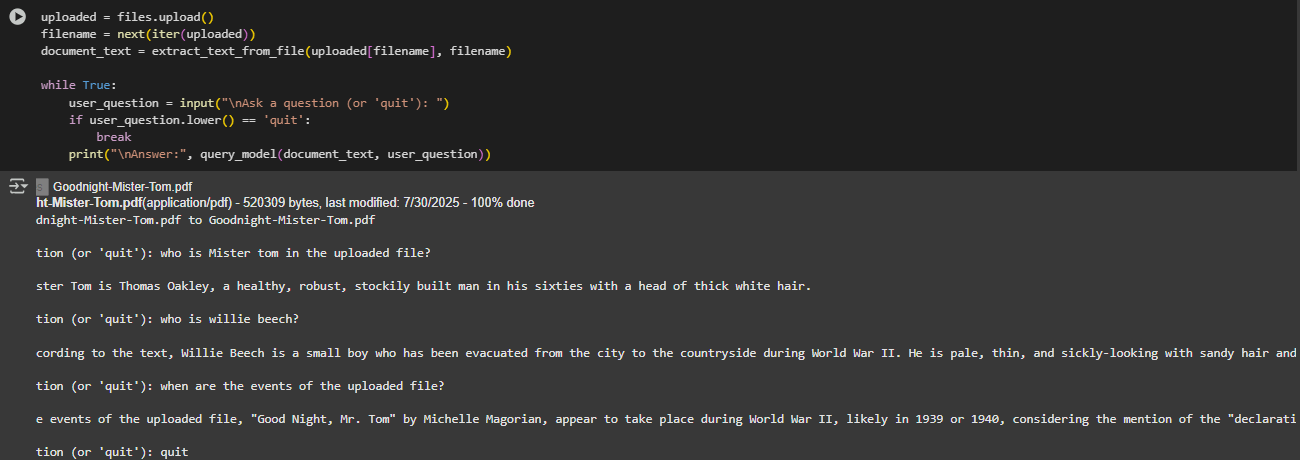

# Wapping Everything Within a Class, Adding Aariables for Variety

gave the privious code to our good fellow deepSeek and it suggested to add the abilit to have the model and some other components as a variables to give the users more freedom in choosing what works for them more.

alos it did wrapp the code in a class even though it was not a request. i noticed it does that a lot, but it does make it more structuraly sound so i will not complain about it

In [16]:
import os
import io
from typing import Union, Dict
from groq import Groq
from google.colab import files, userdata
import PyPDF2
import pandas as pd
import json

class DocumentQA:
    """A class for document-based question answering using Groq."""

    SUPPORTED_FILE_TYPES = {'.pdf', '.csv', '.json', '.txt'}
    DEFAULT_MODEL = "llama3-8b-8192"
    MAX_CONTEXT_LENGTH = 8000

    def __init__(self):
        """Initialize with Groq API client."""
        try:
            self.client = Groq(api_key=userdata.get('GROQ_API_KEY'))
        except Exception as e:
            raise RuntimeError(f"Failed to initialize Groq client: {str(e)}")

        self.document_text = ""
        self.filename = ""

    def _validate_file_type(self, filename: str) -> None:
        """Validate if the file type is supported."""
        if not any(filename.lower().endswith(ext) for ext in self.SUPPORTED_FILE_TYPES):
            raise ValueError(
                f"Unsupported file type '{os.path.splitext(filename)[1]}'. "
                f"Supported types: {', '.join(self.SUPPORTED_FILE_TYPES)}"
            )

    def extract_text(self, uploaded_bytes: bytes, filename: str) -> str:
        """Extract text from supported file formats."""
        self.filename = filename
        self._validate_file_type(filename)

        try:
            if filename.endswith('.pdf'):
                with io.BytesIO(uploaded_bytes) as pdf_file:
                    reader = PyPDF2.PdfReader(pdf_file)
                    return "\n".join(
                        page.extract_text() or f"[PDF Page {i+1} - No extractable text]"
                        for i, page in enumerate(reader.pages)
                    )

            elif filename.endswith('.json'):
                data = json.loads(uploaded_bytes.decode('utf-8'))
                return json.dumps(data, indent=2)[:10000]

            elif filename.endswith('.csv'):
                df = pd.read_csv(io.BytesIO(uploaded_bytes))
                return df.to_string(max_rows=50)

            elif filename.endswith('.txt'):
                return uploaded_bytes.decode('utf-8')

        except Exception as e:
            raise RuntimeError(f"Error processing {filename}: {str(e)}")

    def query_model(self, text: str, question: str, model: str = DEFAULT_MODEL) -> str:
        """Query the model with the given text and question."""
        if not question.strip():
            return "Please provide a non-empty question."

        truncated_text = text[:self.MAX_CONTEXT_LENGTH]

        prompt = (
            f"Analyze this document (from {self.filename}) and answer the question.\n"
            f"Document excerpt:\n{truncated_text}\n\n"
            f"Question: {question}\n"
            "Answer concisely and accurately based only on the document:"
        )

        try:
            response = self.client.chat.completions.create(
                messages=[{"role": "user", "content": prompt}],
                model=model,
                temperature=0.3,
                max_tokens=1024,
            )
            return response.choices[0].message.content.strip()
        except Exception as e:
            return f"API Error: {str(e)}"

    def interactive_session(self) -> None:
        """Run an interactive Q&A session."""
        print(f"\nLoaded document: {self.filename}")
        print("Type 'quit' or 'exit' to end the session.\n")

        while True:
            try:
                user_question = input("\nYour question: ").strip()

                if user_question.lower() in ('quit', 'exit'):
                    break

                if not user_question:
                    print("Please enter a question.")
                    continue

                answer = self.query_model(self.document_text, user_question)
                print(f"\nAnswer:\n{answer}")

            except KeyboardInterrupt:
                print("\nSession ended by user.")
                break
            except Exception as e:
                print(f"Error: {str(e)}")

def main():
    """Main execution flow."""
    try:
        qa = DocumentQA()

        print("Please upload a document (PDF/CSV/JSON/TXT):")
        uploaded = files.upload()

        if not uploaded:
            print("No file uploaded. Exiting.")
            return

        filename = next(iter(uploaded))
        qa.document_text = qa.extract_text(uploaded[filename], filename)

        qa.interactive_session()

    except Exception as e:
        print(f"Fatal error: {str(e)}")

if __name__ == "__main__":
    main()

# Sample Outputs

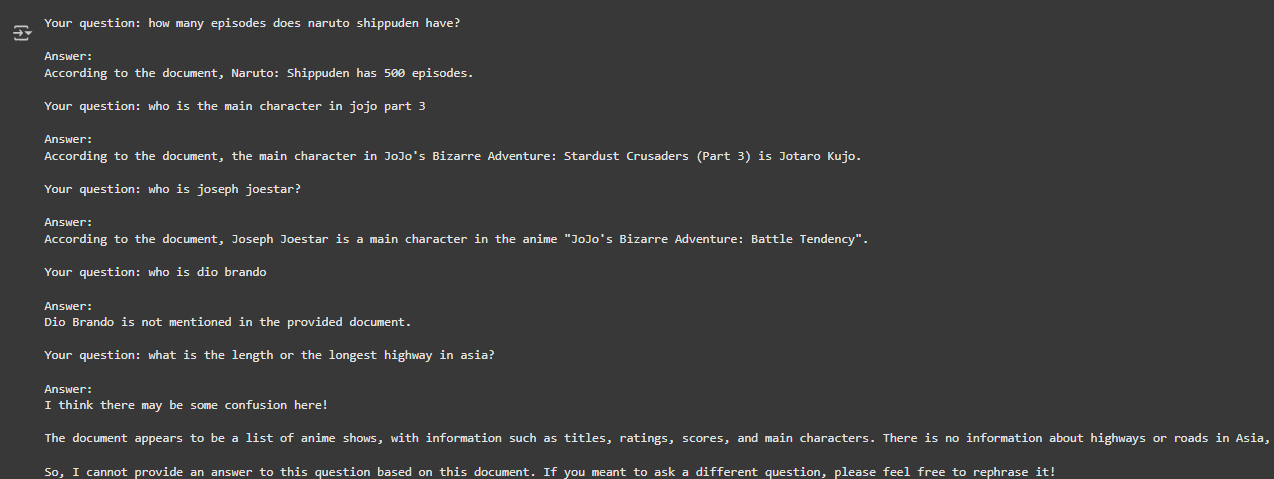

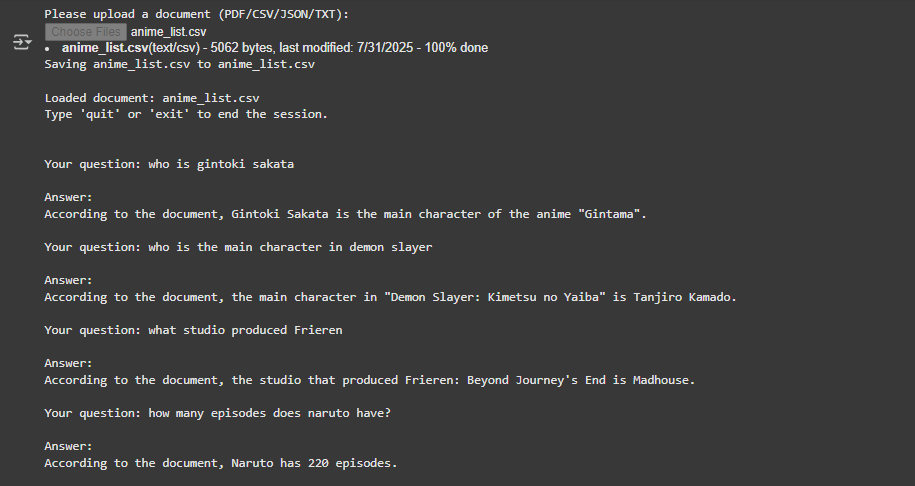

#EMBEDDING

Adding vector emmedings to the code now as a best practice and also to enable future storage with either pgvector or any suitable tool.

Also adding new variables for what is needed like the embedding model and the size of each chunk

Using Cosin similarity to check weither what it considers to relivant is actually....relivant (it is annoying to see it everytime before getting to the answer, but best practice)

In [13]:
!pip install -q groq PyPDF2 pandas faiss-cpu sentence-transformers

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 31.3/31.3 MB 46.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 89.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 72.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 47.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 5.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 12.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 6.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 71.4 MB/s eta 0:00:00


In [16]:
import os
import io
import numpy as np
import faiss
from typing import List, Tuple, Dict, Optional
from groq import Groq
from google.colab import files, userdata
import PyPDF2
import pandas as pd
import json
from sentence_transformers import SentenceTransformer
from sklearn.preprocessing import normalize

class DocumentQAWithEmbeddings:
    """Enhanced Document QA with vector embeddings and retrieval."""

    SUPPORTED_FILE_TYPES = {'.pdf', '.csv', '.json', '.txt'}
    DEFAULT_MODEL = "llama3-8b-8192"
    MAX_CONTEXT_LENGTH = 8000
    CHUNK_SIZE = 512
    EMBEDDING_MODEL = "all-MiniLM-L6-v2"

    def __init__(self):
        try:
            self.client = Groq(api_key=userdata.get('GROQ_API_KEY'))
            self.embedder = SentenceTransformer(self.EMBEDDING_MODEL)
            self.index = None
            self.chunks = []
            self.filename = ""
        except Exception as e:
            raise RuntimeError(f"Initialization failed: {str(e)}")

    def _validate_file_type(self, filename: str) -> None:
        """Validate if the file type is supported."""
        file_ext = os.path.splitext(filename.lower())[1]
        if file_ext not in self.SUPPORTED_FILE_TYPES:
            raise ValueError(
                f"Unsupported file type '{file_ext}'. "
                f"Supported types: {', '.join(self.SUPPORTED_FILE_TYPES)}"
            )

    def _chunk_text(self, text: str) -> List[str]:
        """Split text into manageable chunks."""
        words = text.split()
        chunks = [
            ' '.join(words[i:i + self.CHUNK_SIZE])
            for i in range(0, len(words), self.CHUNK_SIZE)
        ]
        return chunks

    def _create_embeddings_index(self, chunks: List[str]) -> None:
        """Generate embeddings and build FAISS index."""
        embeddings = self.embedder.encode(chunks, convert_to_tensor=False)
        embeddings = normalize(embeddings, axis=1, norm='l2')  # Normalize for cosine similarity

        self.index = faiss.IndexFlatIP(embeddings.shape[1])  # Inner product (cosine similarity)
        self.index.add(embeddings.astype(np.float32))
        self.chunks = chunks

    def extract_text(self, uploaded_bytes: bytes, filename: str) -> None:
        """Extract and index document text."""
        self.filename = filename
        self._validate_file_type(filename)

        try:
            if filename.endswith('.pdf'):
                with io.BytesIO(uploaded_bytes) as pdf_file:
                    reader = PyPDF2.PdfReader(pdf_file)
                    full_text = "\n".join(
                        page.extract_text() or f"[PDF Page {i+1} - No extractable text]"
                        for i, page in enumerate(reader.pages)
                    )

            elif filename.endswith('.json'):
                data = json.loads(uploaded_bytes.decode('utf-8'))
                full_text = json.dumps(data, indent=2)[:10000]

            elif filename.endswith('.csv'):
                df = pd.read_csv(io.BytesIO(uploaded_bytes))
                full_text = df.to_string(max_rows=50)

            elif filename.endswith('.txt'):
                full_text = uploaded_bytes.decode('utf-8')

            chunks = self._chunk_text(full_text)
            self._create_embeddings_index(chunks)

        except Exception as e:
            raise RuntimeError(f"Error processing {filename}: {str(e)}")

    def retrieve_relevant_chunks(self, query: str, k: int = 3) -> List[Tuple[str, float]]:
        """Retrieve top-k most relevant chunks using vector similarity."""
        if not self.index:
            raise RuntimeError("Document not loaded - nothing to search")

        query_embedding = self.embedder.encode(query, convert_to_tensor=False)
        query_embedding = normalize(query_embedding.reshape(1, -1), axis=1, norm='l2')

        distances, indices = self.index.search(
            query_embedding.astype(np.float32),
            k=min(k, len(self.chunks))
        )

        return [
            (self.chunks[i], 1 - distances[0][j])  # Convert to similarity score
            for j, i in enumerate(indices[0])
        ]

    def query_model(self, question: str, model: str = DEFAULT_MODEL) -> str:
        """Enhanced query with retrieval-augmented generation."""
        if not question.strip():
            return "Please provide a non-empty question."

        try:
            relevant_chunks = self.retrieve_relevant_chunks(question)
            context = "\n\n".join(
                f"[Relevant excerpt {i+1}, similarity: {score:.2f}]:\n{chunk}"
                for i, (chunk, score) in enumerate(relevant_chunks)
            )

            prompt = (
                f"Document: {self.filename}\n"
                f"Relevant context:\n{context[:6000]}\n\n"
                f"Question: {question}\n"
                "Answer concisely and accurately based only on the provided context. "
                "If unsure, say you don't know."
            )

            response = self.client.chat.completions.create(
                messages=[{"role": "user", "content": prompt}],
                model=model,
                temperature=0.3,
                max_tokens=1024,
            )
            return response.choices[0].message.content.strip()

        except Exception as e:
            return f"Error: {str(e)}"

    def interactive_session(self) -> None:
        """Run interactive session with retrieval feedback."""
        print(f"\nLoaded document: {self.filename}")
        print("Type 'quit' or 'exit' to end the session.\n")

        while True:
            try:
                user_question = input("\nYour question: ").strip()

                if user_question.lower() in ('quit', 'exit'):
                    break

                if not user_question:
                    print("Please enter a question.")
                    continue

                relevant_chunks = self.retrieve_relevant_chunks(user_question)
                print("\nTop matching sections:")
                for i, (chunk, score) in enumerate(relevant_chunks, 1):
                    print(f"\n[{i}] Similarity: {score:.2f}")
                    print(chunk[:200] + ("..." if len(chunk) > 200 else ""))

                answer = self.query_model(user_question)
                print(f"\nAnswer:\n{answer}")

            except KeyboardInterrupt:
                print("\nSession ended by user.")
                break
            except Exception as e:
                print(f"Error: {str(e)}")

def main():
    """Main execution flow."""
    try:
        qa = DocumentQAWithEmbeddings()

        print("Please upload a document (PDF/CSV/JSON/TXT):")
        uploaded = files.upload()

        if not uploaded:
            print("No file uploaded. Exiting.")
            return

        filename = next(iter(uploaded))
        qa.extract_text(uploaded[filename], filename)
        qa.interactive_session()

    except Exception as e:
        print(f"Fatal error: {str(e)}")

if __name__ == "__main__":
    main()

# Sample Outputs

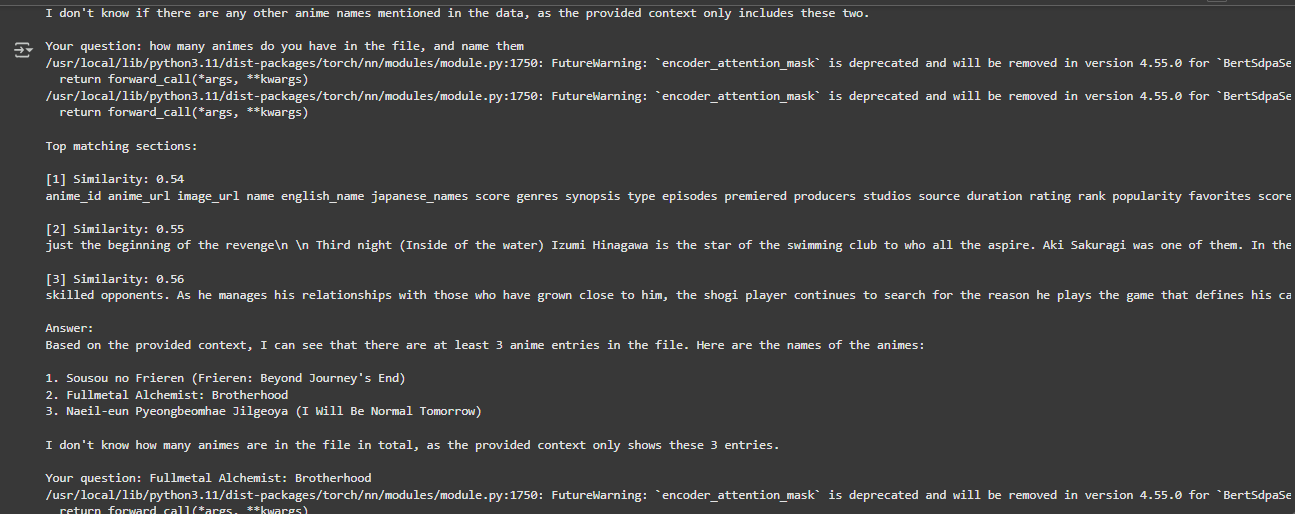

# memory efficiency, overlapping chunks, and metadata tracking

the next list of updates are as follows:

Do not load the model unless unless needed. Save memory. that was something cool to do.

Allow some overlapping between chunks to prevent like a single portion of informations to be separated.

If something is asked and an embedding is made, show where was the info found in. Allows for tracking and double checking the info.

Also, now for the csv which is the main type of files i test with. it will now deal with it line by line instead of all at once. because the privious ones denied the existance of info that i myself put in the files. so taking in line by line helped a lot and it is now more accurate

In [15]:
!pip install -q groq PyPDF2 pandas faiss-cpu sentence-transformers

In [16]:
import os
import io
import re
import numpy as np
import faiss
from typing import List, Tuple, Dict, Optional
from groq import Groq
from google.colab import files, userdata
import PyPDF2
import pandas as pd
import json
from sentence_transformers import SentenceTransformer
from sklearn.preprocessing import normalize

class DocumentQAWithEmbeddings:
    """Enhanced Document QA with memory efficiency, overlapping chunks, and metadata tracking."""

    SUPPORTED_FILE_TYPES = {'.pdf', '.csv', '.json', '.txt'}
    DEFAULT_MODEL = "llama3-8b-8192"
    MAX_CONTEXT_LENGTH = 24000
    CHUNK_SIZE = 4096
    CHUNK_OVERLAP = 50
    EMBEDDING_MODEL = "all-MiniLM-L6-v2"

    def __init__(self):
        try:
            self.client = Groq(api_key=userdata.get('GROQ_API_KEY'))
            self._embedder = None
            self.index = None
            self.chunks = []
            self.metadata = []
            self.filename = ""
        except Exception as e:
            raise RuntimeError(f"Initialization failed: {str(e)}")

    @property
    def embedder(self):
        """Lazy-load the embedding model to save memory."""
        if self._embedder is None:
            self._embedder = SentenceTransformer(self.EMBEDDING_MODEL)
        return self._embedder

    def _preprocess_text(self, text: str) -> str:
        """Clean text before chunking."""
        text = re.sub(r'\s+', ' ', text).strip()
        text = re.sub(r'-\n', '', text)  #
        return text

    def _chunk_text(self, text: str) -> List[str]:
        """Split text into overlapping chunks with word boundaries."""
        text = self._preprocess_text(text)
        words = text.split()
        chunks = [
            ' '.join(words[i:i + self.CHUNK_SIZE])
            for i in range(0, len(words), self.CHUNK_SIZE - self.CHUNK_OVERLAP)
            if i < len(words)
        ]
        return chunks

    def _create_embeddings_index(self, chunks: List[str]) -> None:
        """Generate embeddings with metadata tracking."""
        embeddings = self.embedder.encode(chunks, convert_to_tensor=False)
        embeddings = normalize(embeddings, axis=1, norm='l2')

        # store metadata for each chunk
        self.metadata = []
        word_count = 0
        for i, chunk in enumerate(chunks):
            chunk_word_count = len(chunk.split())
            self.metadata.append({
                "source": self.filename,
                "chunk_id": i,
                "start_word": word_count,
                "end_word": word_count + chunk_word_count,
                "content_type": "text"  # can be specialized per file type
            })
            word_count += (chunk_word_count - self.CHUNK_OVERLAP)

        self.index = faiss.IndexFlatIP(embeddings.shape[1])
        self.index.add(embeddings.astype(np.float32))
        self.chunks = chunks

    def _validate_file_type(self, filename: str) -> None:
        """Validate if the file type is supported."""
        file_ext = os.path.splitext(filename.lower())[1]
        if file_ext not in self.SUPPORTED_FILE_TYPES:
            raise ValueError(
                f"Unsupported file type '{file_ext}'. "
                f"Supported types: {', '.join(self.SUPPORTED_FILE_TYPES)}"
            )

    def extract_text(self, uploaded_bytes: bytes, filename: str) -> None:
        """Enhanced text extraction for all file types with metadata awareness."""
        self.filename = filename
        self._validate_file_type(filename)

        try:
            full_text = ""
            if filename.endswith('.pdf'):
                with io.BytesIO(uploaded_bytes) as pdf_file:
                    reader = PyPDF2.PdfReader(pdf_file)
                    full_text_pages = []
                    for i, page in enumerate(reader.pages):
                        page_text = page.extract_text() or f"[PDF Page {i+1} - No extractable text]"
                        full_text_pages.append((i+1, page_text))  # Track page numbers
                    full_text = "\n".join(text for _, text in full_text_pages)

            elif filename.endswith('.json'):
                data = json.loads(uploaded_bytes.decode('utf-8'))
                if isinstance(data, dict):
                    full_text = json.dumps(data, indent=2)
                else:
                    full_text = "\n".join(json.dumps(item, indent=2) for item in data)

            elif filename.endswith('.csv'):
                df = pd.read_csv(io.BytesIO(uploaded_bytes))

                # Chunk each row as individual entry
                chunks = []
                for _, row in df.iterrows():
                    row_text = "\n".join(f"{col}: {row[col]}" for col in df.columns)
                    chunks.append(row_text)

                # schema metadata
                self.metadata = [{
                    "columns": list(df.columns),
                    "dtypes": str(df.dtypes.to_dict()),
                    "source": filename,
                    "chunk_id": i,
                    "start_word": 0,
                    "end_word": 0,
                    "content_type": "csv_row"
                } for i in range(len(chunks))]

                self._create_embeddings_index(chunks)
                return  # early return to avoid redundant chunking below


            elif filename.endswith('.txt'):
                full_text = uploaded_bytes.decode('utf-8')

            chunks = self._chunk_text(full_text)
            self._create_embeddings_index(chunks)

        except Exception as e:
            raise RuntimeError(f"Error processing {filename}: {str(e)}")

    def retrieve_relevant_chunks(self, query: str, k: int = 10) -> List[Tuple[str, float, Dict]]:
        """Retrieve chunks with similarity scores and metadata."""
        if not self.index:
            raise RuntimeError("Document not loaded - nothing to search")

        query_embedding = self.embedder.encode(query, convert_to_tensor=False)
        query_embedding = normalize(query_embedding.reshape(1, -1), axis=1, norm='l2')

        distances, indices = self.index.search(
            query_embedding.astype(np.float32),
            k=min(k, len(self.chunks))
        )

        return [
            (self.chunks[i], 1 - distances[0][j], self.metadata[i])
            for j, i in enumerate(indices[0])
        ]

    def query_model(self, question: str, model: str = DEFAULT_MODEL) -> str:
        """Generate answers with source references."""
        relevant_chunks = self.retrieve_relevant_chunks(question)
        context = "\n\n".join(
            f"[Source: {meta['source']}, words {meta['start_word']}-{meta['end_word']}]:\n"
            f"{chunk[:500]}{'...' if len(chunk) > 500 else ''}"
            for chunk, _, meta in relevant_chunks
        )

        prompt = (
            f"Document: {self.filename}\n"
            f"Relevant context:\n{context}\n\n"
            f"Question: {question}\n"
            "Answer concisely and reference source locations like 'See words 120-180'."
        )

        response = self.client.chat.completions.create(
            messages=[{"role": "user", "content": prompt}],
            model=model,
            temperature=0.3,
            max_tokens=1024
        )
        return response.choices[0].message.content.strip()

    def interactive_session(self) -> None:
        """Run interactive session with metadata-aware feedback."""
        print(f"\nLoaded document: {self.filename}")
        print("Type 'quit' or 'exit' to end the session.\n")

        while True:
            try:
                user_question = input("\nYour question: ").strip()
                if user_question.lower() in ('quit', 'exit'):
                    break

                relevant_chunks = self.retrieve_relevant_chunks(user_question)
                # print("\nTop matching sections:")
                # for i, (chunk, score, meta) in enumerate(relevant_chunks, 1):
                #     print(f"\n[{i}] Similarity: {score:.2f} | Words {meta['start_word']}-{meta['end_word']}")
                #     print(chunk[:200] + ("..." if len(chunk) > 200 else ""))

                answer = self.query_model(user_question)
                print(f"\nAnswer:\n{answer}")

            except KeyboardInterrupt:
                print("\nSession ended by user.")
                break
            except Exception as e:
                print(f"Error: {str(e)}")

def main():
    """Main execution flow."""
    try:
        qa = DocumentQAWithEmbeddings()

        print("Please upload a document (PDF/CSV/JSON/TXT):")
        uploaded = files.upload()

        if not uploaded:
            print("No file uploaded. Exiting.")
            return

        filename = next(iter(uploaded))
        qa.extract_text(uploaded[filename], filename)
        qa.interactive_session()

    except Exception as e:
        print(f"Fatal error: {str(e)}")

if __name__ == "__main__":
    main()

# Sample Outputs

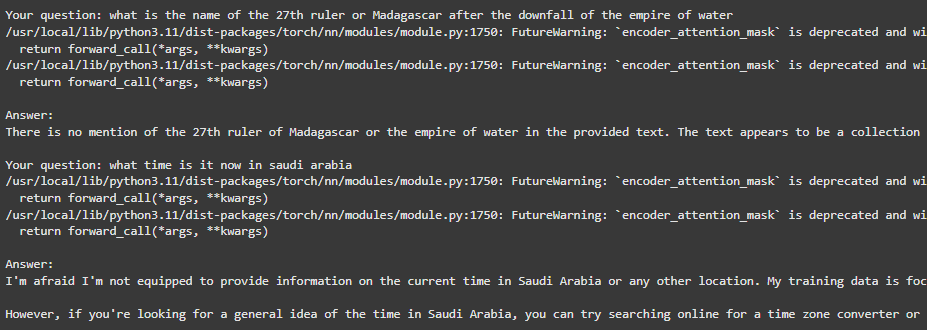

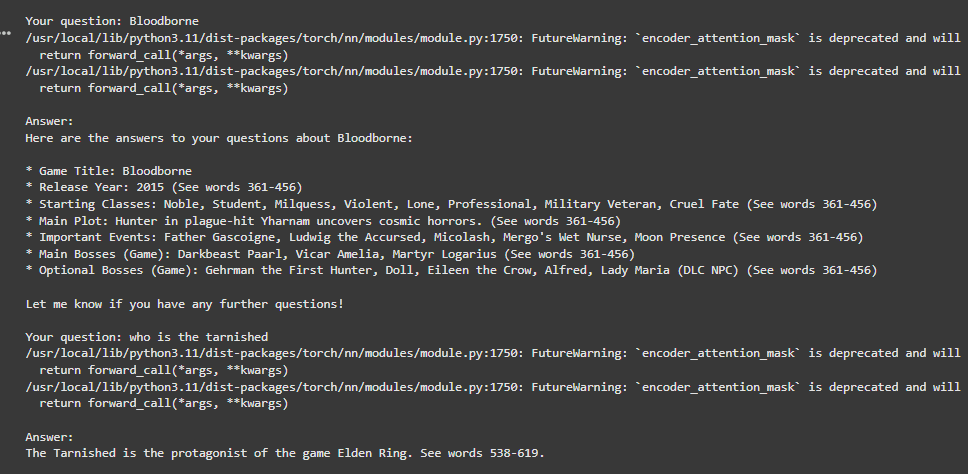

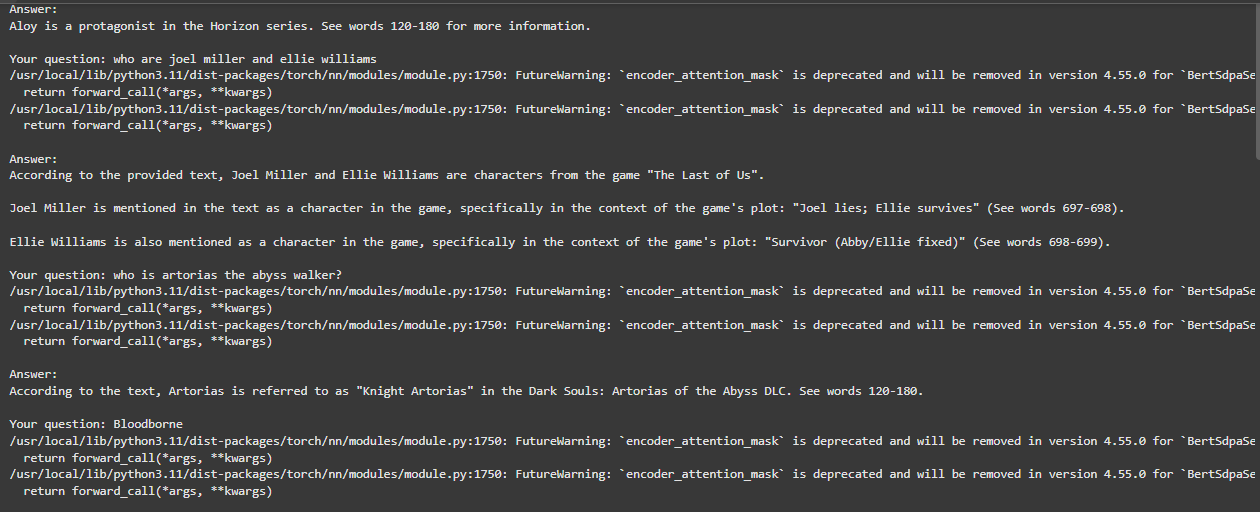

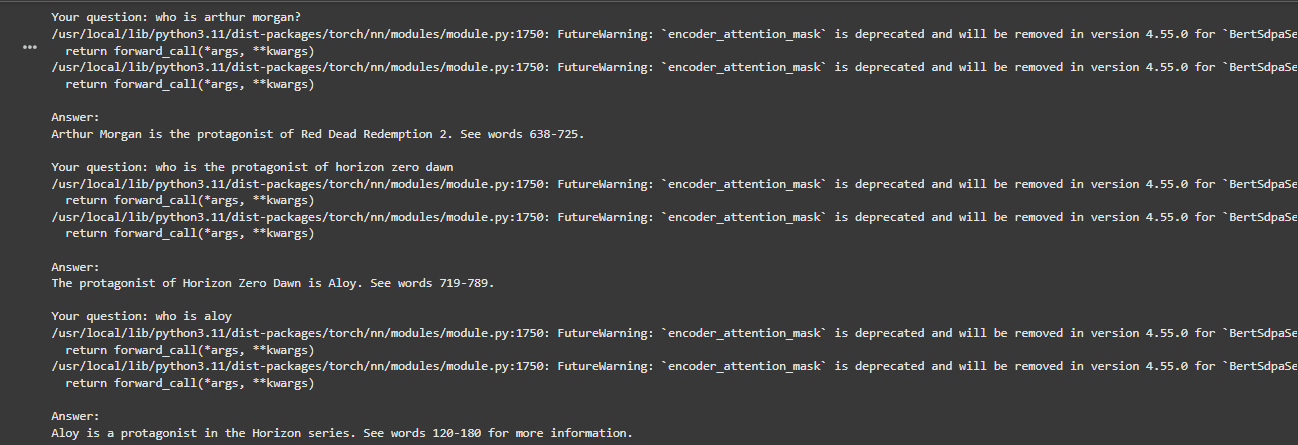